In [1]:
import os
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import Lasso.lasso_model as Lasso
import PCR.PCR_model as PCR
import Random_Forest.rf_model as RF
import XGBoost.xgboost_model as XGBoost

# Multi-Horizon Evaluation of Inflation Forecasting Models

This notebook evaluates the predictive performance of four forecasting models across multiple time horizons. The evaluation is designed to reflect a realistic decision-making environment, as faced by economists, analysts, and policymakers when producing forecasts for 1 to 12 months ahead.


---

## Structure of the Notebook

### 1. **Data and Preprocessing**
- Import and preparation of the dataset.
- Target variable: Inflation.
- Explanatory variables: A range of macroeconomic indicators.

### 2. **Rolling Forecast Evaluation (1–12 Month Horizons)**
- For each forecast origin, models are trained on past data and generate forecasts for *h = 1, ..., 12* months ahead.
- Evaluated models:
  - LASSO (regularized linear regression)
  - Principal Component Regression (PCR)
  - Random Forest
  - XGBoost
- Forecast accuracy is assessed using:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
- This setup allows us to compare how well each model performs over short, medium, and long forecast horizons.


---

## Objective of the Notebook

The goal is:  
**To systematically evaluate the predictive accuracy of different forecasting models across time and forecast horizons — thereby identifying which methods are most reliable for short- and long-term inflation forecasting.**



# 1. Data and Preprocessing

In [5]:
# Navigate to data folder
os.chdir('Data')

# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 221)


In [6]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 220)


# Functions

In [8]:
def run_all_forecasters(X, y, forecast_horizon, last_observation_date, scaler, trees, window_length=108, verbose=True):
    """
    Run LASSO, XGBoost, PCR, and Random Forest forecasters and combine their forecasts in one DataFrame.

    Args:
        X: DataFrame of predictors
        y: Series of the target variable
        forecast_horizon: int, number of steps ahead to forecast
        last_observation_date: str or pd.Timestamp, origin date for forecasting
        scaler: fitted sklearn scaler
        trees: int, number of trees for Random Forest
        window_length: int, size of the rolling window (default: 108 months)
        verbose: bool, whether to print model details
    Returns:
        pd.DataFrame with forecasts from all models
    """

    # --- Run LASSO ---
    lasso_df = Lasso.lasso_forecast(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    
    lasso_df.rename(columns={"Inflation forecast": "LASSO"}, inplace=True)

        
    # --- Run XGBoost ---
    xgb_df = XGBoost.XGBoost_Forecaster(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    xgb_df.rename(columns={"Inflation forecast": "XGBoost"}, inplace=True)

    # --- Run PCR ---
    pcr_df = PCR.pcr_forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        variance_threshold=0.95,
        window_length=window_length,
        verbose=verbose
    )
    pcr_df.rename(columns={"Inflation forecast": "PCR"}, inplace=True)

    # --- Run Random Forest ---
    rf_df = RF.RandomForest_Forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        trees=trees,
        window_length=window_length,
        verbose=verbose
    )
    rf_df.rename(columns={"Inflation forecast": "RandomForest"}, inplace=True)

    # --- Merge all forecasts on Date and Horizon ---
    combined_df_old = lasso_df[["Date", "Horizon", "LASSO"]] \
        .merge(xgb_df[["Date", "XGBoost"]], on="Date") \
        .merge(pcr_df[["Date", "PCR"]], on="Date") \
        .merge(rf_df[["Date", "RandomForest"]], on="Date")
    
    combined_df = lasso_df[["Date", "Horizon", "LASSO"]] \
    .merge(xgb_df[["Date", "Horizon", "XGBoost"]], on=["Date", "Horizon"]) \
    .merge(pcr_df[["Date", "Horizon", "PCR"]], on=["Date", "Horizon"]) \
    .merge(rf_df[["Date", "Horizon", "RandomForest"]], on=["Date", "Horizon"])


    return combined_df

def evaluate_window_lengths(X, y, window_lengths, forecast_horizon, last_observation_date, scaler, trees):
    results = []

    for w in window_lengths:
        print(f"\n--- Testing window_length={w} ---")
        try:
            forecast_df = run_all_forecasters(
                X=X,
                y=y,
                forecast_horizon=forecast_horizon,
                last_observation_date=last_observation_date,
                scaler=scaler,
                trees=trees,
                window_length=w,
                verbose=False
            )

            benchmark_df = forecast_df.merge(y.reset_index(), on="Date", how="left")
            mae_scores = {
                model: mean_absolute_error(benchmark_df["Inflation"], benchmark_df[model])
                for model in ["LASSO", "XGBoost", "PCR", "RandomForest"]
            }

            mae_scores["window_length"] = w
            results.append(mae_scores)

        except Exception as e:
            print(f"Window length {w} failed: {e}")

    return pd.DataFrame(results)

def run_all_forecasters_and_evaluate(X, y, forecast_horizon, start_date, end_date, window_length=108, trees=100):
    """
    Run forecasts from all models and return both forecast dataframe and evaluation (MAE/RMSE per horizon).
    """
    all_model_forecasts = []

    model_funcs = {
        "LASSO": Lasso.run_rolling_forecast,
        "XGBoost": XGBoost.run_rolling_forecast,
        "PCR": PCR.run_rolling_forecast,
        "RandomForest": RF.run_rolling_forecast,
    }

    for model_name, func in model_funcs.items():
        print(model_name)
        df = func(
            X=X, y=y,
            forecast_horizon=forecast_horizon,
            start_date=start_date,
            end_date=end_date,
            window_length=window_length
        )
        df["Model"] = model_name
        all_model_forecasts.append(df)

    forecasts_df = pd.concat(all_model_forecasts, ignore_index=True)
    #forecasts_df = forecasts_df.rename(columns={"Inflation forecast": "Forecast", "Date": "Dato"})
    #forecasts_df = forecasts_df[["Date", "Horizon", "Forecast_made_in", "Model", "Forecast"]]
    
    forecasts_df = forecasts_df.rename(columns={"Inflation forecast": "Forecast"})
    forecasts_df = forecasts_df[["Date", "Horizon", "Forecast_made_in", "Model", "Forecast"]]

    # forecasts_df, evaluation_df
    return forecasts_df



def evaluate_all_models(forecasts_df, y, metric="RMSE"):
    """
    Evaluates forecasts from each model and returns a wide-format DataFrame:
    - Rows: forecast horizons (plus 'Acc.' row)
    - Columns: model names + n_obs
    - Values: RMSE or MAE, rounded to 3 decimals

    Args:
        forecasts_df (pd.DataFrame): Forecast output with columns 'Date', 'Model', 'Forecast', 'Horizon'
        y (pd.Series): True target values (indexed by date)
        metric (str): "RMSE" or "MAE"

    Returns:
        pd.DataFrame: Evaluation matrix with one row per horizon and one "Acc." row
    """
    import pandas as pd

    evaluation_all = []

    for model in forecasts_df["Model"].unique():
        model_df = forecasts_df[forecasts_df["Model"] == model].copy()
        model_df = model_df.rename(columns={"Forecast": "Inflation forecast"})
        eval_df, _ = Lasso.evaluate_forecasts(model_df, y)
        eval_df["Model"] = model
        evaluation_all.append(eval_df)

    # Combine evaluations
    evaluation_df = pd.concat(evaluation_all, ignore_index=True)

    # Get model evaluation matrix
    wide_eval = evaluation_df.pivot_table(
        index="Horizon",
        columns="Model",
        values=metric
    ).reset_index()

    # --- Get N_obs from one model (they are all the same) ---
    n_obs_per_horizon = (
        evaluation_df[["Horizon", "N_obs"]]
        .drop_duplicates(subset="Horizon")
        .reset_index(drop=True)
    )

    # Merge into wide matrix
    wide_eval = wide_eval.merge(n_obs_per_horizon, on="Horizon", how="left")

    # --- Compute accumulated error (Acc.) ---
    model_names = [col for col in wide_eval.columns if col not in ["Horizon", "N_obs"]]
    acc_row = {"Horizon": "Acc.", "N_obs": ""}
    for model in model_names:
        acc_row[model] = round(wide_eval[model].sum(), 3)

    wide_eval = wide_eval._append(acc_row, ignore_index=True)

    # Round all numeric columns to 3 decimals
    for col in model_names:
        wide_eval[col] = wide_eval[col].astype(float).round(3)

    return wide_eval


# 2. **Training Window Selection (Grid Search)**

Before performing rolling forecasts, we evaluate how the length of the training window affects forecast accuracy.  
Using a simple grid search over different window lengths (e.g., 60, 84, 96, 108, 120 months), we estimate 1-month-ahead forecasts across a validation period and compare performance.

The objective is to select the window length that provides the best balance between bias and variance — large enough to capture macroeconomic patterns, but short enough to adapt to structural shifts.

The selected optimal window length is then used throughout the remaining forecasting exercises.

In [10]:
%%time
window_lengths_to_test = [24, 36, 48, 60, 84, 96, 108, 120]
results_df = evaluate_window_lengths(
    X=X,
    y=y,
    window_lengths=window_lengths_to_test,
    forecast_horizon=12,
    last_observation_date="2022-12-01",
    scaler=scaler,
    trees=250
)


--- Testing window_length=24 ---

--- Testing window_length=36 ---

--- Testing window_length=48 ---

--- Testing window_length=60 ---

--- Testing window_length=84 ---

--- Testing window_length=96 ---

--- Testing window_length=108 ---

--- Testing window_length=120 ---
CPU times: user 5min 47s, sys: 7min 35s, total: 13min 22s
Wall time: 2min 55s


In [11]:
results_df

,LASSO,XGBoost,PCR,RandomForest,window_length
0,5.936700,5.417972,6.292798,5.227787,24
1,4.845492,5.321578,5.843181,4.986067,36
2,5.256456,5.081819,5.473091,4.961053,48
3,5.528148,5.397421,5.719728,5.084889,60
4,5.131439,5.308796,5.617533,5.012237,84
5,5.597221,5.475959,5.367380,5.041494,96
6,5.915826,5.282681,5.425557,5.038719,108
7,4.506009,5.122898,5.523178,5.113602,120


From this table, we observe that:
- **XGBoost consistently outperforms the other models**, achieving the lowest MAE in most window settings.
- PCR shows relatively stable performance across window lengths, suggesting that the model is less sensitive to training sample size than LASSO or Random Forest.
- The optimal window length for most models lies between **84 and 96 months**, after which performance either plateaus or worsens.
- LASSO shows more variability and appears to degrade with longer windows.

These findings highlight the importance of choosing an appropriate window size, especially for regularized or tree-based models in a rolling forecasting setup.


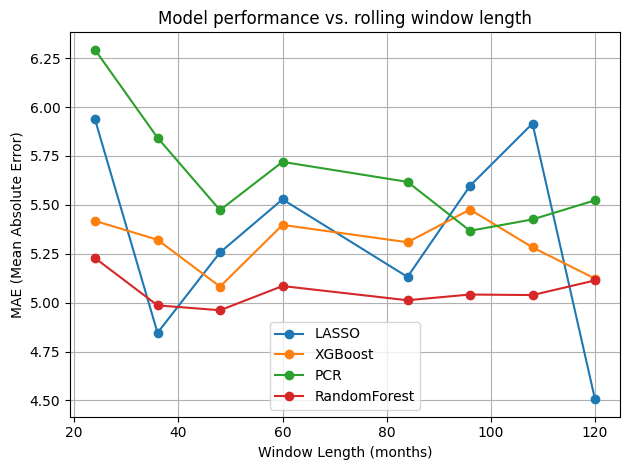

In [13]:
# Plot each model's MAE across window lengths
for model in ["LASSO", "XGBoost", "PCR", "RandomForest"]:
    plt.plot(results_df["window_length"], results_df[model], marker='o', label=model)

plt.title("Model performance vs. rolling window length")
plt.xlabel("Window Length (months)")
plt.ylabel("MAE (Mean Absolute Error)")
#plt.axvline(96, color='grey', linestyle='--', alpha=0.6, label="Selected window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**We select 96 months as the preferred training window, as it offers a stable performance across models and avoids the degradation seen with longer windows.**

# 4. Rolling Forecast Evaluation (Multi-Horizon)

With the training window length now selected, we evaluate the performance of each model in a realistic real-time forecasting setting.

Following the procedure in Garcia et al. (2017), we implement a multi-horizon rolling forecast framework. At each point in time (from January 2023 to December 2024), each model is re-estimated using the most recent 96 months of data and used to generate forecasts \( h = 1, .. , 12 \) months ahead.

This approach mimics the constraints faced by practitioners: models are trained only on data available up to that point and updated sequentially over time. Performance is then evaluated out-of-sample using RMSE (and optionally MAE) at each horizon.

> Note: The function `run_all_forecasters_and_evaluate()` is computationally intensive and takes several minutes to execute.  
This is because each model is re-trained multiple times — once for every evaluation date — across all forecast horizons.  
Especially tree-based methods like Random Forest are time-consuming due to their repeated fitting and internal optimization steps.



In [17]:
%%time
forecasts_df = run_all_forecasters_and_evaluate(
    X=X, 
    y=y, 
    forecast_horizon=12, 
    start_date="2022-01-01",
    end_date="2024-12-01",
    window_length=84,
    trees=250
)

LASSO
XGBoost
PCR
RandomForest
CPU times: user 18min 57s, sys: 24min 33s, total: 43min 31s
Wall time: 10min 39s


#### Forecast Accuracy by Model and Horizon

The following tables show RMSE and MAE for each model across forecast horizons \( h = 1, .., 12 \).

In [20]:
rmse_matrix = evaluate_all_models(forecasts_df, y, metric="RMSE")
rmse_matrix

,Horizon,LASSO,PCR,RandomForest,XGBoost,N_obs
0,0,0.848,0.871,1.101,0.825,35
1,1,1.632,1.624,1.965,1.581,34
2,2,1.832,1.903,2.418,2.083,33
3,3,2.682,2.325,2.893,2.759,32
4,4,3.472,2.996,3.749,3.233,31
5,5,3.898,3.573,3.840,3.481,30
6,6,4.286,4.159,3.978,3.934,29
7,7,5.312,4.769,4.463,4.384,28
8,8,5.543,4.990,4.889,4.849,27
9,9,5.235,4.984,5.341,5.303,26


In [21]:
mae_matrix = evaluate_all_models(forecasts_df, y, metric="MAE")
mae_matrix

,Horizon,LASSO,PCR,RandomForest,XGBoost,N_obs
0,0,0.667,0.689,0.848,0.641,35
1,1,1.255,1.353,1.572,1.296,34
2,2,1.394,1.446,1.920,1.785,33
3,3,2.023,1.796,2.464,2.363,32
4,4,2.677,2.355,3.317,2.741,31
5,5,3.052,2.815,3.355,2.807,30
6,6,3.206,3.210,3.315,3.150,29
7,7,3.667,3.536,3.749,3.690,28
8,8,4.118,3.627,4.355,4.110,27
9,9,4.147,3.762,4.974,4.808,26


Across both RMSE and MAE, XGBoost and LASSO generally outperform Random Forest and PCR, especially at shorter horizons.

- **XGBoost** shows the lowest error at short horizons (e.g., \( h = 1 \)), and maintains relatively stable performance up to \( h = 6 \).
- **LASSO** performs competitively throughout, especially when strong regularization reduces overfitting at longer horizons.
- **Random Forest** and **PCR** show higher errors, particularly beyond 6 months, likely due to overfitting (in RF) or lack of adaptation (in PCR).

This confirms that model choice matters more at longer horizons, and that regularized or boosting-based methods may be better suited for inflation forecasting under structural change.


In [23]:
rmse_matrix_clean = rmse_matrix[rmse_matrix["Horizon"] != "Acc."].iloc[:, 0:-1]
mae_matrix_clean = mae_matrix[mae_matrix["Horizon"] != "Acc."].iloc[:, 1:-1]

rmse_matrix_clean

,Horizon,LASSO,PCR,RandomForest,XGBoost
0,0,0.848,0.871,1.101,0.825
1,1,1.632,1.624,1.965,1.581
2,2,1.832,1.903,2.418,2.083
3,3,2.682,2.325,2.893,2.759
4,4,3.472,2.996,3.749,3.233
5,5,3.898,3.573,3.840,3.481
6,6,4.286,4.159,3.978,3.934
7,7,5.312,4.769,4.463,4.384
8,8,5.543,4.990,4.889,4.849
9,9,5.235,4.984,5.341,5.303


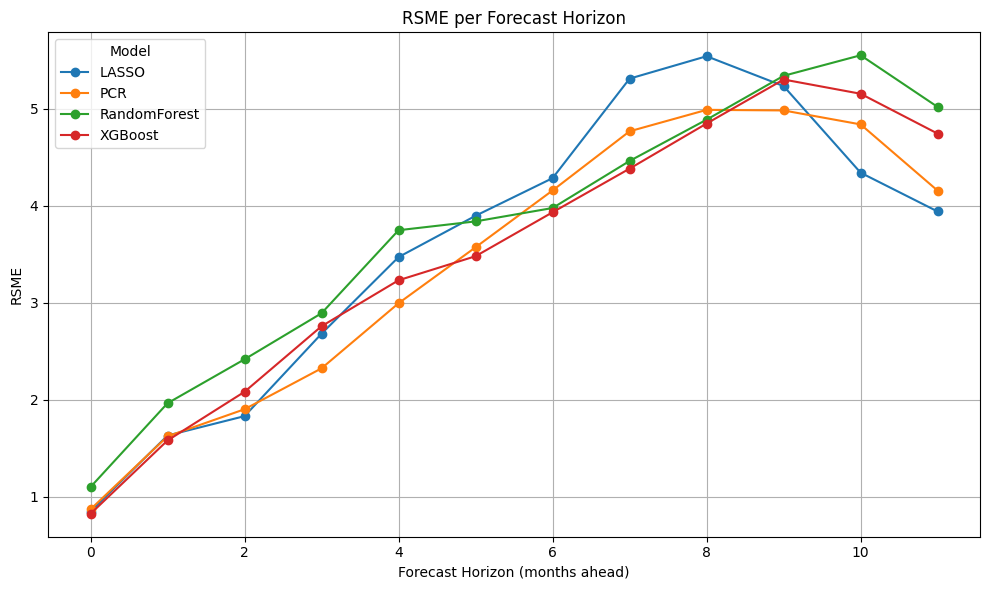

In [24]:
plt.figure(figsize=(10, 6))

for model in rmse_matrix_clean.columns[1:]:  # Skip 'Horizon' column
    plt.plot(
        rmse_matrix_clean["Horizon"],
        rmse_matrix_clean[model],
        marker="o",
        label=model
        )

plt.title(f"RSME per Forecast Horizon")
plt.xlabel("Forecast Horizon (months ahead)")
plt.ylabel("RSME")
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()

As expected, forecast accuracy declines with increasing horizon length.  
XGBoost and LASSO generally achieve lower RMSE values, particularly at shorter horizons.  
Random Forest and PCR perform relatively worse, with higher errors at longer horizons, possibly due to overfitting (RF) or insufficient flexibility (PCR).

This comparison highlights the importance of model selection when forecasting inflation beyond the short term.

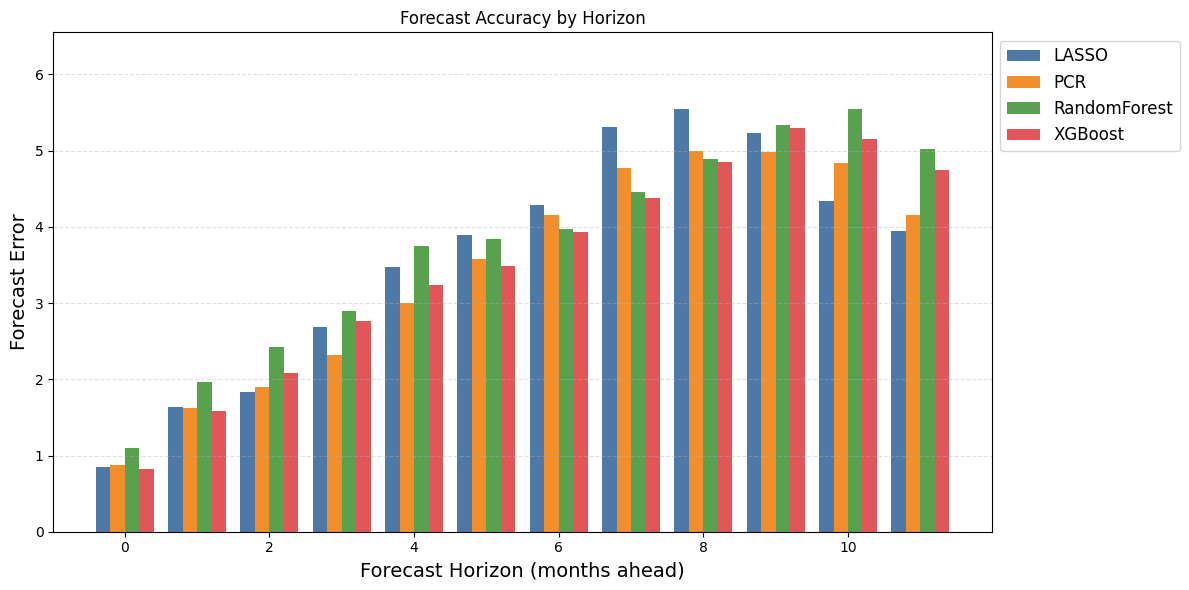

In [26]:
#  Set up the figure
plt.figure(figsize=(12, 6))
h = rmse_matrix_clean["Horizon"]
bar_width = 0.2

# Define custom colors for each model
colors = ["#4E79A7", "#F28E2B", "#59A14F", "#E15759"]  # blå, orange, grøn, rød

# Plot bars for each model at shifted positions
plt.bar(h - 1.5*bar_width, rmse_matrix_clean["LASSO"], width=bar_width, color=colors[0], label="LASSO")
plt.bar(h - 0.5*bar_width, rmse_matrix_clean["PCR"], width=bar_width, color=colors[1], label="PCR")
plt.bar(h + 0.5*bar_width, rmse_matrix_clean["RandomForest"], width=bar_width, color=colors[2], label="RandomForest")
plt.bar(h + 1.5*bar_width, rmse_matrix_clean["XGBoost"], width=bar_width, color=colors[3], label="XGBoost")

# Axis labels and title
plt.xlabel("Forecast Horizon (months ahead)", fontsize=14)
plt.ylabel("Forecast Error", fontsize=14)
plt.title("Forecast Accuracy by Horizon")

# Customize ticks and grid
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.ylim(0, rmse_matrix_clean.drop(columns="Horizon").values.max() + 1)

# Legend placed outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

# Optimize layout
plt.tight_layout()
plt.show()

## Barplot

In [28]:
# Forecast accuracy data extracted from the 3 levels
# Manuelt indtastet, svært at køre alle nivuear simultant
cpi_data = {
    "Level": ["Level 0 (Headline)", "Level 1 (12 Groups)", "Level 2 (Disaggregated)"],
    "Lasso_RMSE": [42.18, 42.58, 44.265],
    "PCR_RMSE": [40.94, 41.42, 44.604],
    "RF_RMSE": [45.26, 45.28, 44.932],
    "XGB_RMSE": [42.18, 42.95, 43.137],
    "Lasso_MAE": [32.87, 32.40, 33.411],
    "PCR_MAE": [33.48, 31.60, 33.480],
    "RF_MAE": [39.00, 39.60, 39.020],
    "XGB_MAE": [36.54, 36.34, 36.537]
}
#

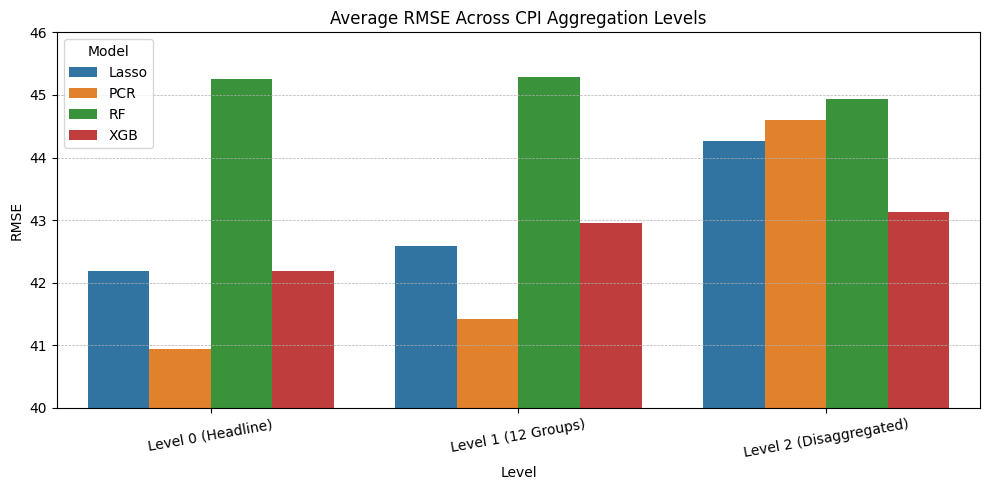

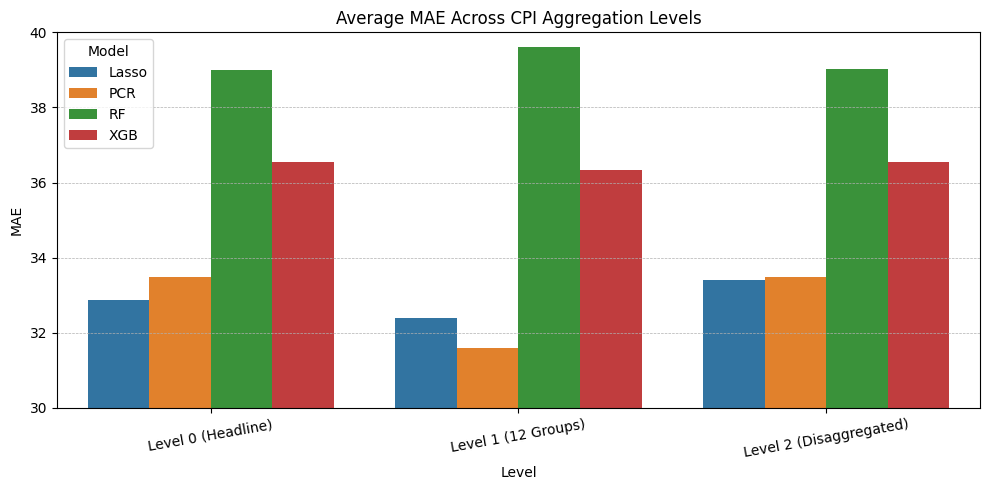

In [29]:
df_cpi = pd.DataFrame(cpi_data)

# Melt for RMSE and MAE plots
df_rmse = df_cpi.melt(id_vars="Level", value_vars=["Lasso_RMSE", "PCR_RMSE", "RF_RMSE", "XGB_RMSE"],
                  var_name="Model", value_name="RMSE")
df_rmse["Model"] = df_rmse["Model"].str.replace("_RMSE", "")

df_mae = df_cpi.melt(id_vars="Level", value_vars=["Lasso_MAE", "PCR_MAE", "RF_MAE", "XGB_MAE"],
                 var_name="Model", value_name="MAE")
df_mae["Model"] = df_mae["Model"].str.replace("_MAE", "")

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_rmse, x="Level", y="RMSE", hue="Model")
plt.title("Average RMSE Across CPI Aggregation Levels")
plt.ylabel("RMSE")
plt.ylim(40, 46)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=10)
plt.tight_layout()
#plt.savefig("RMSE_barplot.png")
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_mae, x="Level", y="MAE", hue="Model")
plt.title("Average MAE Across CPI Aggregation Levels")
plt.ylabel("MAE")
plt.ylim(30, 40)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=10)
plt.tight_layout()
#plt.savefig("MAE_barplot.png")
plt.show()



In [30]:
cpi_data_avg = {
    "Level": ["Level 0 (Headline)", "Level 1 (12 Groups)", "Level 2 (Disaggregated)"],
    "Lasso_RMSE": [42.18/12, 42.58/12, 44.265/12],
    "PCR_RMSE": [40.94/12, 41.42/12, 44.604/12],
    "RF_RMSE": [45.26/12, 45.28/12, 44.932/12],
    "XGB_RMSE": [42.18/12, 42.95/12, 43.137/12],
    "Lasso_MAE": [32.87/12, 32.40/12, 33.411/12],
    "PCR_MAE": [33.48/12, 31.60/12, 33.480/12],
    "RF_MAE": [39.00/12, 39.60/12, 39.020/12],
    "XGB_MAE": [36.54/12, 36.34/12, 36.537/12]
}
cpi_data_avg

{'Level': ['Level 0 (Headline)',
  'Level 1 (12 Groups)',
  'Level 2 (Disaggregated)'],
 'Lasso_RMSE': [3.515, 3.5483333333333333, 3.68875],
 'PCR_RMSE': [3.4116666666666666, 3.4516666666666667, 3.717],
 'RF_RMSE': [3.7716666666666665, 3.7733333333333334, 3.7443333333333335],
 'XGB_RMSE': [3.515, 3.579166666666667, 3.59475],
 'Lasso_MAE': [2.7391666666666663, 2.6999999999999997, 2.78425],
 'PCR_MAE': [2.7899999999999996, 2.6333333333333333, 2.7899999999999996],
 'RF_MAE': [3.25, 3.3000000000000003, 3.251666666666667],
 'XGB_MAE': [3.045, 3.0283333333333338, 3.04475]}

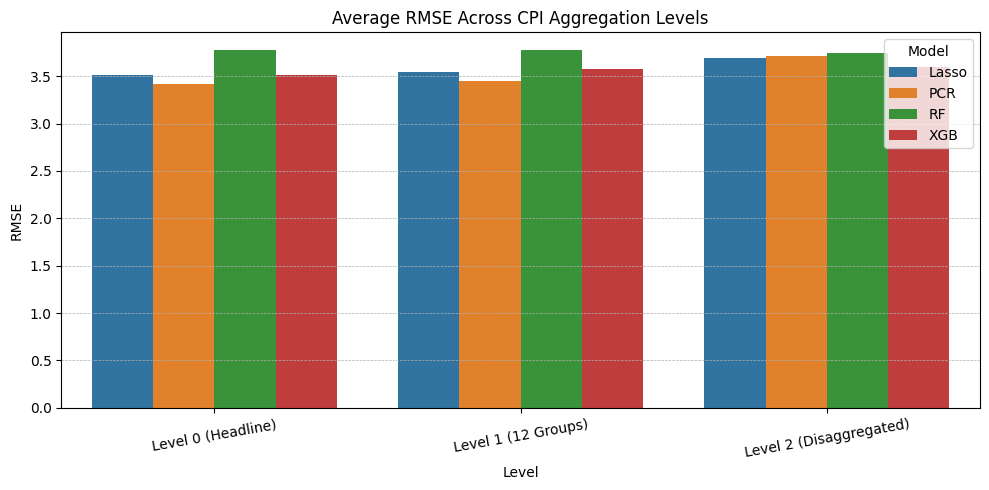

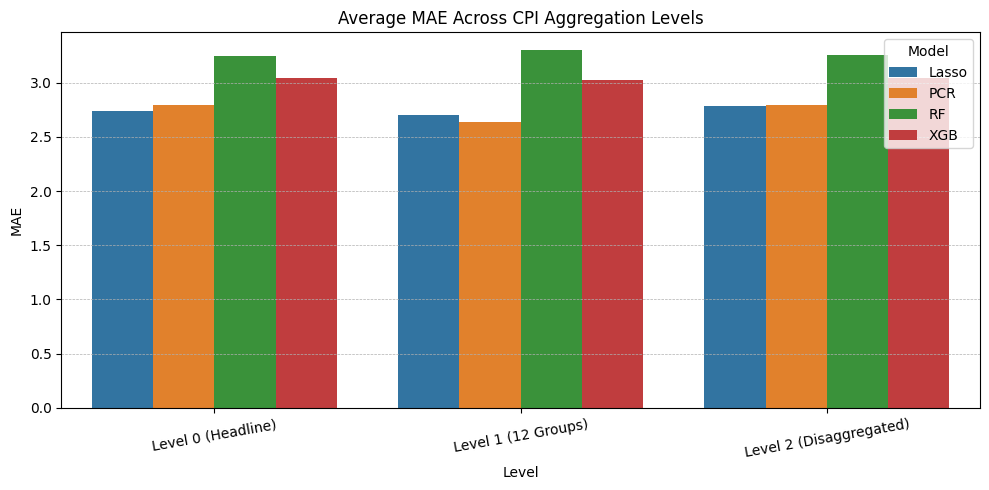

In [31]:
df_cpi = pd.DataFrame(cpi_data_avg)

# Melt for RMSE and MAE plots
df_rmse = df_cpi.melt(id_vars="Level", value_vars=["Lasso_RMSE", "PCR_RMSE", "RF_RMSE", "XGB_RMSE"],
                  var_name="Model", value_name="RMSE")
df_rmse["Model"] = df_rmse["Model"].str.replace("_RMSE", "")

df_mae = df_cpi.melt(id_vars="Level", value_vars=["Lasso_MAE", "PCR_MAE", "RF_MAE", "XGB_MAE"],
                 var_name="Model", value_name="MAE")
df_mae["Model"] = df_mae["Model"].str.replace("_MAE", "")

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_rmse, x="Level", y="RMSE", hue="Model")
plt.title("Average RMSE Across CPI Aggregation Levels")
plt.ylabel("RMSE")
#plt.ylim(4, 4.6)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=10)
plt.tight_layout()
#plt.savefig("RMSE_barplot.png")
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
sns.barplot(data=df_mae, x="Level", y="MAE", hue="Model")
plt.title("Average MAE Across CPI Aggregation Levels")
plt.ylabel("MAE")
#plt.ylim(3, 4)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=10)
plt.tight_layout()
#plt.savefig("MAE_barplot.png")
plt.show()

